---
title: "Indexing PXRD data with Convolutional Neural Networks"
format:
  html:
    code-overflow: scroll
    code-fold: true
    code-summary: "Show the code"
author: Mark Spillman
categories:
- PXRD
- Machine learning
- Synthetic data
- Indexing
date: '2024-02-11'
description: Using convolutional neural networks to index PXRD data
image: images/MAPE.png
toc: true
---

# Introduction

In a [previous post](https://mspillman.github.io/blog/posts/2023-09-08-Generating-synthetic-PXRD-data.html), I covered how to make relatively realistic looking PXRD data from the pre-processed Miller indices, d-spacings and intensity values stored in the [PowCod database](https://www.researchgate.net/publication/273507012_QUALX20_A_qualitative_phase_analysis_software_using_the_freely_available_database_POW-COD). We ended up with [some code](https://github.com/mspillman/powcodgen/) that can be used to rapidly generate synthetic PXRD data using a GPU, via the PyTorch library.

In this post, we'll make use of this code to train convolutional neural networks (CNNs) to determine the lattice parameters directly from the PXRD data. This has been done before, notably by [Habershorn et al in 2004](https://pubs.acs.org/doi/10.1021/jp0310596) and more recently in this open access paper by [Chitturi et al](https://scripts.iucr.org/cgi-bin/paper?vb5020) in 2021.

As such, a good starting point will be to replicate the results by Chitturi and coworkers before trying more modern neural network architectures to see if we can improve the performance a bit!

Let's start by loading the data, and taking a look at how things stack up against the dataset used by Chitturi et al.

In [1]:
#| code-fold: true
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


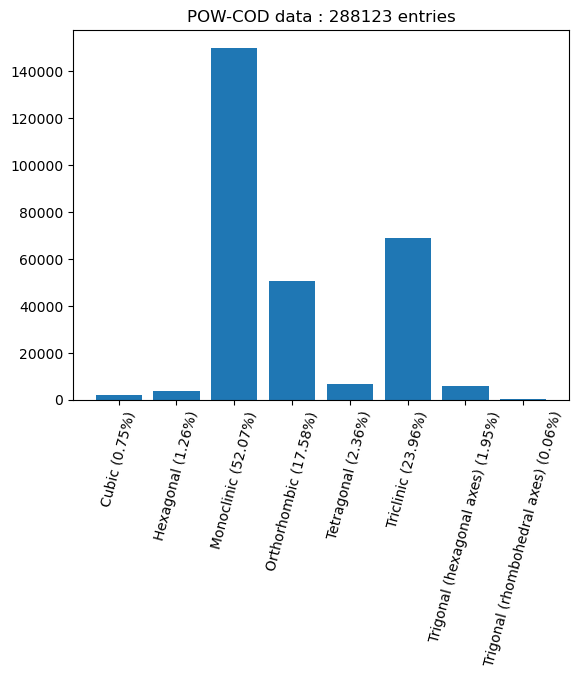

In [2]:
#| code-fold: true
base_name = "4-44-CuKa1-data_4000_"
root_dir = "./"
cs = np.load(root_dir+base_name+"crystal_systems_numeric.npy")
cs_key =  {
    "Cubic" : 0,
    "Hexagonal" :  1,
    "Monoclinic" : 2,
    "Orthorhombic" : 3,
    "Tetragonal" : 4,
    "Triclinic" : 5,
    "Trigonal (hexagonal axes)" : 6,
    "Trigonal (rhombohedral axes)" : 7
}
crystal_systems = np.unique(cs, return_counts=True)
plt.bar(height=crystal_systems[1], x=[f"{x} ({100*float(crystal_systems[1][i])/cs.shape[0]:.2f}%)" for i, x in enumerate(list(cs_key.keys()))])
plt.xticks(rotation=75)
plt.title(f"POW-COD data : {len(cs)} entries")
plt.show()

cubic_data = np.where(cs == 0)[0]
hex_data = np.where(cs == 1)[0]
monoclinic_data = np.where(cs == 2)[0]
orthorhombic_data = np.where(cs == 3)[0]
tetrag_data = np.where(cs == 4)[0]
triclinic_data = np.where(cs == 5)[0]
# Ignore the trigonal!
trimonoortho = np.sort(np.hstack([monoclinic_data, orthorhombic_data, triclinic_data]))

As we saw in the last post, we have a pretty significant imbalance in the distribution of the data into the different crystal systems. This is similar to what was found in the combined ICSD and CSD data used by Chitturi, who obtained the following plot:

![Chitturi et al, 2021](images/Chitturi_datasets.png)

Where (a) shows the data in the ICSD, (b) shows the data in the CSD and (c) shows the combined dataset they used to train their models.

It also seems like we have a substantially smaller dataset, weighing in at about 200k samples, compared to about 950k samples for Chitturi. However, I suspect that the data augmentation strategies we developed in the previous post should be able to help counteract this shortfall.

# Replicating results
Let's have a go at replicating the results by Chitturi et al. They decided to train different models for each of the crystal systems in their dataset. Given the relatively small dataset I have available, I'll focus on the three most populated (and coincidentally most complex / lowest symmetry) crystal systems: triclinic, monoclinic and orthorhombic.

First, we'll need a nice to load the data - let's make a pytorch Dataset object to allow us to easily load the data. We can then easily define a training, and validation split from this. I've also added the option to specify indices of interest, which will allow us to pull out the specific crystal systems we want to train on.

In [3]:
class DiffractionData(Dataset):

    def __init__(self,base_name, root_dir="./", idx=None, dtype=torch.float32):
        if idx is not None:
            self.crystal_system_numeric = torch.tensor(np.load(root_dir+base_name+"crystal_systems_numeric.npy")[idx], dtype=dtype)
            self.hkl                    = torch.tensor(np.load(root_dir+base_name+"hkl.npy")[idx], dtype=dtype)
            self.intensities            = torch.tensor(np.load(root_dir+base_name+"intensities.npy")[idx], dtype=dtype)
            self.unit_cell              = torch.tensor(np.load(root_dir+base_name+"unit_cell.npy")[idx], dtype=dtype)
            # Use extinctions rather than space groups
            self.sg_number              = torch.tensor(np.load(root_dir+base_name+"extinction_number.npy")[idx], dtype=dtype)
        else:
            self.crystal_system_numeric = torch.tensor(np.load(root_dir+base_name+"crystal_systems_numeric.npy"), dtype=dtype)
            self.hkl                    = torch.tensor(np.load(root_dir+base_name+"hkl.npy"), dtype=dtype)
            self.intensities            = torch.tensor(np.load(root_dir+base_name+"intensities.npy"), dtype=dtype)
            self.unit_cell              = torch.tensor(np.load(root_dir+base_name+"unit_cell.npy"), dtype=dtype)
            # Use extinctions rather than space groups
            self.sg_number              = torch.tensor(np.load(root_dir+base_name+"extinction_number.npy"), dtype=dtype)

    def __len__(self):
        return len(self.intensities)

    def __getitem__(self, idx):
        return self.crystal_system_numeric[idx], self.hkl[idx], self.intensities[idx], self.unit_cell[idx], self.sg_number[idx]

base_name = "4-44-CuKa1-data_4000_"
root_dir = "./"

device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
dtype = torch.float32

We can now prepare our neural network model. I've _almost_ replicated the one in the paper (same number of layers), but made a slight difference to the first linear layer due to the different data resolution I'm using.

Chitturi et al make use of data with a resolution of 0.01 degrees per step (90 degree data range, 9000 steps), but then also use an initial MaxPooling layer with pool size of 3, meaning that the average resolution being fed into the first convolutional layer is 0.03 degrees per step. In my case, I'll opt to use a resolution of 0.019 degrees per step (via 40 degree data range / 2048 steps), and so have chosen to omit the initial pooling layer from my implementation. The difference in data resolution also means that the dimensionality of the first linear layer will be different from Chitturi's model. However, overall the architecture is very similar, and a similar total number of parameters is obtained:

| Model          | Parameters |
|----------------|------------|
| Chitturi et al | 78248      |
| Replication    | 80292      |

The model is fairly straightforward, with blocks of convolutional and pooling layers, followed by a stack of linear layers. I've implemented a module for the blocks, and then stacked them together with the linear layers to create the model.

In [13]:
#| code-fold: true
class ChitturiConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, pool=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(in_dim, out_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(out_dim, out_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(pool),
        )
    def forward(self, x):
        return self.layers(x)

class ChitturiModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            #nn.MaxPool1d(2),
            ChitturiConvBlock(1, 5, pool=2),
            ChitturiConvBlock(5, 10, pool=2),
            ChitturiConvBlock(10, 15, pool=3),
            ChitturiConvBlock(15, 20, pool=2),
            ChitturiConvBlock(20, 30, pool=3),
            nn.Flatten(),
            nn.Linear(840, 80),
            nn.ReLU(),
            nn.Linear(80, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.ReLU(),
            nn.Linear(10, 3),
        ])

    def forward(self, x, shapes=False):
        for l in self.layers:
            if shapes:
                print(x.shape)
            x = l(x)
        if shapes:
            print(x.shape)
        return x

model = ChitturiModel().to(device)
_ = model(torch.randn(100,1,2048).to(device), shapes=False)
print("Model parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

Model parameters: 80298


This model should give us a reasonable baseline which we can try to improve on later in this post. What we now need is a training loop which includes the following:
- Data generation with augmentation strategies (see previous post)
- Model predictions
- Model loss calculation (and other metrics)
- Model training
- Validation loss calculation (and other metrics)

Chitturi et al trained their model using the [Huber](https://en.m.wikipedia.org/wiki/Huber_loss) loss function. This is a loss function that is designed to be more robust against outliers compared to the mean squared error, whilst encouraging convergence using a quadratic loss when the error is low. We'll use the same loss function, but also calculate the mean squared error (MSE), the mean absolute error (MAE) and the mean absolute percentage error (MAPE) as additional metrics for this regression task. The MAPE will be the most convenient metric to use to compare against Chitturi's model as this is reported in the article for several different variations of model they trained.

Another thing to point out is that Chitturi et al trained models on "perfect" data, and then sequentially added in different augmentations (e.g. baseline noise, zero point errors etc). In the interest of time I'll just dive straight in with training the model with all of the augmentation strategies employed rather than adding them incrementally.

Let's define the data generation parameters

In [4]:
# Data generation parameters

from powcodgen import patterns
from tqdm.auto import tqdm

# Data generation parameters
# ------------------------------------------------------------
ttmin = 4                       # Minimum data twotheta angle
ttmax = 44                      # Maximum data twotheta angle
peakrange = 3.                  # Buffer for peaks to move beyond the data range
datadim = 2048                  # Number of points in PXRD histograms
same_hwhm = False               # Impurity data has same peak shape & hwhm as the dominant phase
min_impurity_intensity = 0.02   # Minimum intensity for impurity peaks
max_impurity_intensity = 0.15   # Maximum intensity for impurity peaks
add_background = True           # Include an amorphous background (Chebyshev)
# ------------------------------------------------------------

# Create the tensors used as the PXRD histograms
full_data = torch.linspace(ttmin-(peakrange/2), ttmax+(peakrange/2),
                        int(np.ceil((ttmax-ttmin+peakrange)/((ttmax-ttmin)/datadim))),
                        device=device, dtype=dtype)
x = (full_data[full_data <= ttmin+(peakrange/2)]).clone() - ttmin

Now for the training loop

In [5]:
#| code-fold: true
# Training / validation code
def get_loss(dataloader, model, optimizer, epoch, train=True, show_pbar=True):
    """
    Get the losses for an epoch. Toggle between the dataloaders so the same code can be recycled
    for the training and validation sets.
    """
    if show_pbar:
        pbar = tqdm(dataloader)
    else:
        pbar = dataloader
    logs = []
    if not train:
        model.eval()
    for batch_cs, batch_hkl, batch_i, batch_cell, batch_sg_number in pbar:
        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)
        # forward + backward + optimize
        if len(batch_cs) % 2 != 0 or len(batch_cs) % 3 != 0:
            maxlength = 6*(batch_cs.shape[0]//6)
            batch_cs = batch_cs[:maxlength]
            batch_hkl = batch_hkl[:maxlength]
            batch_i = batch_i[:maxlength]
            batch_cell = batch_cell[:maxlength]
            batch_sg_number = batch_sg_number[:maxlength]
        calcdata = patterns.calculate_diffraction_patterns_with_impurities(
                                        x,
                                        full_data,
                                        batch_cs.to(device),
                                        batch_hkl.to(device),
                                        batch_i.to(device),
                                        batch_cell.to(device),
                                        batch_sg_number.to(device),
                                        same_hwhm=same_hwhm,
                                        min_impurity_intensity=min_impurity_intensity,
                                        max_impurity_intensity=max_impurity_intensity,
                                        add_background = add_background,
                                    )
        combined, pure_patterns, impure_patterns, pure_impure, cs, cell, sgs, hkls = calcdata
        abc_pred = model(combined.unsqueeze(1))
        sorted_cell = torch.sort(cell[:,:3], dim=1).values
        mse = F.mse_loss(abc_pred, sorted_cell)
        mae = torch.abs(abc_pred - sorted_cell).mean()
        huber = F.huber_loss(abc_pred, sorted_cell)
        mape = (100*torch.abs(abc_pred - sorted_cell)/sorted_cell).mean()
        if train:
            loss = huber
            loss.backward()
            optimizer.step()
        if show_pbar:
            pbar.set_description_str(f"Epoch: {epoch+1} MSE : {mse.item():.4f} MAE : {mae.item():.4f} MAPE : {mape:.4f} Huber : {huber.item():.4f}")
        logs.append(torch.tensor([[mse, mae, mape, huber]]))
    if not train:
        model.train()
    return logs


def train(model, optimizer, idx, name, batchsize=256, num_epochs=50, show_pbar=True):
    """
    Train a model on a given subset of the POWCOD training data
    """
    dataset = DiffractionData(base_name, root_dir=root_dir, idx=idx)
    g = torch.Generator().manual_seed(42)
    #train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], g)
    train_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2], g)

    train_dataloader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
    val_dataloader   = DataLoader(val_set,   batch_size=batchsize, shuffle=True)
    #test_dataloader  = DataLoader(test_set,  batch_size=batchsize, shuffle=True)

    print(f"Training samples = {len(train_set)}\nValidation samples = {len(val_set)}")#\nTest samples = {len(test_set)}")

    num_steps = (len(train_set)//batchsize) * num_epochs
    print(f"Epochs: {num_epochs} Total gradient updates: {num_steps}")

    all_train_losses = []
    all_val_losses = []
    best_val_mape = float("inf")
    for epoch in range(num_epochs):
        train_losses = get_loss(train_dataloader, model, optimizer, epoch, train=True, show_pbar=show_pbar)
        all_train_losses.append(train_losses)
        train_losses = torch.cat(train_losses, dim=0).mean(dim=0)

        val_losses = get_loss(val_dataloader, model, optimizer, epoch, train=False, show_pbar=show_pbar)
        all_val_losses.append(val_losses)
        val_losses = torch.cat(val_losses, dim=0).mean(dim=0)
        if show_pbar:
            print(f"Train: MSE {train_losses[0]:.3f} MAE {train_losses[1]:.3f} MAPE {train_losses[2]:.3f} Huber {train_losses[3]:.3f}")
            print(f"  Val: MSE {val_losses[0]:.3f} MAE {val_losses[1]:.3f} MAPE {val_losses[2]:.3f} Huber {val_losses[3]:.3f}")
        if val_losses[2] < best_val_mape:
            best_val_mape = val_losses[2]
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"saved_models/{name}.pth")
    return all_train_losses, all_val_losses

One thing to point out is that the code I'm using to generate the impurity phase peaks means that the batch size needed from the dataloader is larger than the batch size seen by the model.

It works by taking in a batch of 3 x _N_ samples. The first _N_ samples is considered "pure", the second _N_ samples will be the dominant phase in the impure data, with the final _N_ samples making up the impurity peaks. The impure data is then produced by summing the patterns produced by the dominant phase and a scaled-down version of the minority phase patterns. In this case, this means that the impurity phases are always guaranteed to be from the same crystal system as the dominant phase. Whilst I appreciate that this isn't the ideal way to do things, it's quick and convenient, and should still allow the models to be relatively robust with respect to the presence of small peaks from impurity phases. If anyone wanted to pick up on this work, then this would be a good place for improvement!

As a result of this impurity-generation strategy, you'll see that I specify the batch size below to be (64*3)//2 = 96. This means that 96 samples will be obtained from the database and have their diffraction patterns generated. These will be split into 32 pure patterns, 32 dominant phase patterns and 32 minority phase patterns (which are randomly scaled down to ensure that the maximum intensity of the impurity patterns falls in the range specified in the settings defined earlier). The dominant phase and impurity phase patterns are then combined, which results in 32 pure patterns + 32 impure patterns, giving a batch size (as seen by the model) of 64. The batch size of 64 (as seen by the model) was chosen to match that used by Chitturi et al.

Let's give this a go, and plot the metrics as a function of epoch for each of the three crystal systems we're testing!

Triclinic
Training samples = 55230
Validation samples = 13807
Epochs: 50 Total gradient updates: 28750
Best Triclinic val MSE: 1.604 MAE: 0.834 MAPE: 7.896 Huber: 0.485


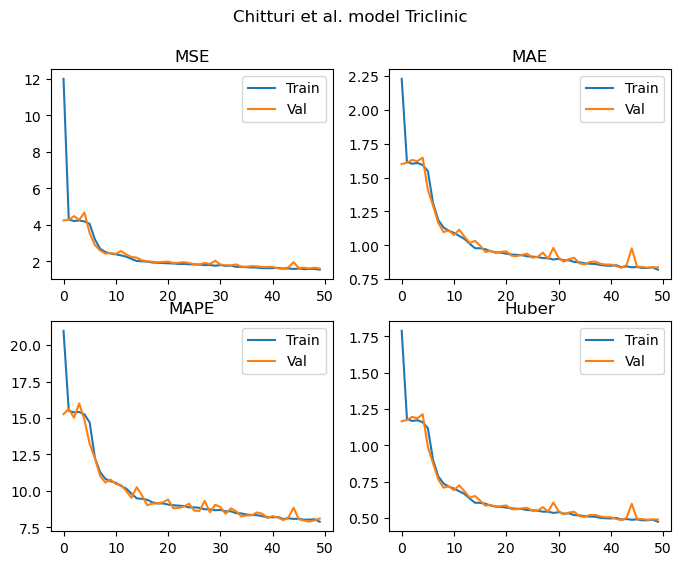


Monoclinic
Training samples = 120031
Validation samples = 30007
Epochs: 50 Total gradient updates: 62500
Best Monoclinic val MSE: 9.230 MAE: 1.969 MAPE: 14.465 Huber: 1.547


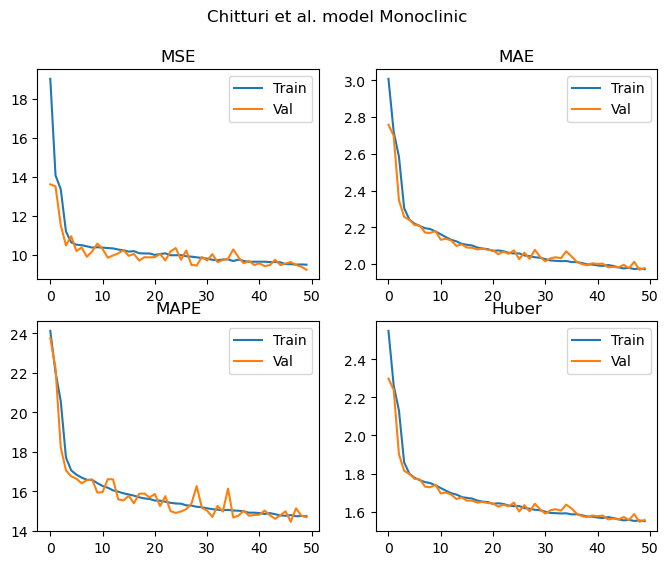


Orthorhombic
Training samples = 40522
Validation samples = 10130
Epochs: 50 Total gradient updates: 21100
Best Orthorhombic val MSE: 10.664 MAE: 2.327 MAPE: 19.489 Huber: 1.882


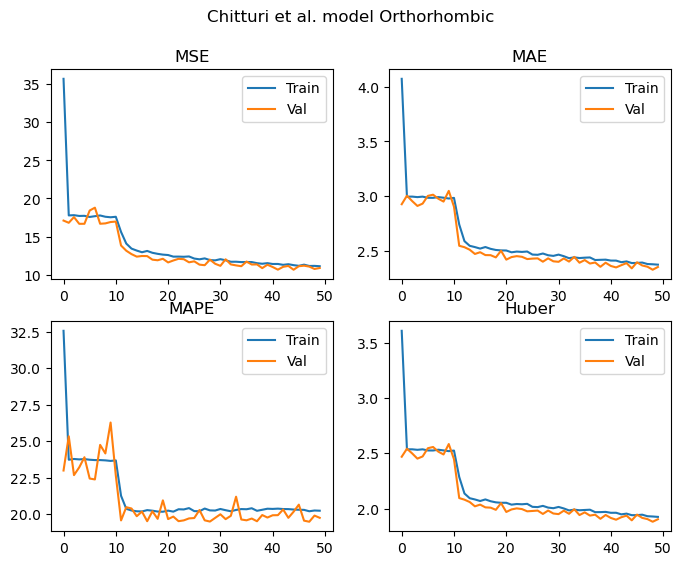

In [7]:
#| code-fold: true
splits = ["Triclinic", "Monoclinic", "Orthorhombic"]
models = []
for i, subset in enumerate([triclinic_data, monoclinic_data, orthorhombic_data]):
    model = ChitturiModel().to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    print(splits[i])
    train_metrics, val_metrics = train(
                                    model=model,
                                    optimizer=optimizer,
                                    idx=subset,
                                    name=f"Chitturi_{splits[i]}",
                                    num_epochs=50,
                                    batchsize=(64*3)//2,
                                    show_pbar=False
                                    )

    # Get the minimum validation loss for each metric
    val_min = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0).min(dim=0).values
    print(f"Best {splits[i]} val MSE: {val_min[0]:.3f} MAE: {val_min[1]:.3f} MAPE: {val_min[2]:.3f} Huber: {val_min[3]:.3f}")

    # Calculate the average loss for each epoch and plot
    train_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in train_metrics]], dim=0)
    val_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
    fig.suptitle("Chitturi et al. model "+splits[i])
    ax[0][0].plot(train_av[:,0])
    ax[0][0].plot(val_av[:,0])
    ax[0][0].title.set_text("MSE")
    ax[0][0].legend(["Train", "Val"])
    ax[0][1].plot(train_av[:,1])
    ax[0][1].plot(val_av[:,1])
    ax[0][1].title.set_text("MAE")
    ax[0][1].legend(["Train", "Val"])
    ax[1][0].plot(train_av[:,2])
    ax[1][0].plot(val_av[:,2])
    ax[1][0].title.set_text("MAPE")
    ax[1][0].legend(["Train", "Val"])
    ax[1][1].plot(train_av[:,3])
    ax[1][1].plot(val_av[:,3])
    ax[1][1].title.set_text("Huber")
    ax[1][1].legend(["Train", "Val"])
    plt.show()
    print()
    models.append(model)

As we can see from the results above, all of the metrics demonstrate that the model is learning to predict the lattice parameters. These curves appear to be still decreasing once we hit 50 epochs, and the validation and training losses are not diverging. As such, the models are undertrained at this point and would likely continue to improve with additional epochs.

In terms of the performance obtained in each case, let's summarise the MAPEs into a table to allow us to easily compare against Chitturi et al's results. You'll see in the table below, two sets of results from Chitturi et al's work. The lower number is for models trained on augmented data and tested exclusively on "perfect" data (i.e. no augmentation). The larger number is for models trained on augmented data and tested exclusively on augmented data.

This differs to what I've done here in that only half of the datasets during both testing and evaluation contain impurities.

| Crystal system | Chitturi et al - (100/0)     | Chitturi et al - (0/100)        | Replication (50/50) |
|----------------|------------------------------|---------------------------------|-------------|
| Triclinic      | 7.50                         | 10.48                           | 7.90        |
| Monoclinic     | 13.50                        | 16.02                           | 14.46       |
| Orthorhombic   | 15.71                        | 19.49                           | 19.49       |

For the triclinic, monoclinic and orthorhombic models, it's nice to see that we achieve similar MAPEs to those reported in the paper despite the significantly smaller dataset.

# Training a ConvNeXt v2 model

Let's now see if a more modern architecture can be used to improve on these baselines. We'll base our new neural network on a recently published convolutional neural network architecture that gives state of the art performance on image classification tasks: [ConvNeXt v2](https://arxiv.org/abs/2301.00808).

The building block of this architecture is the ConvNeXt v2 block, shown in the figure below.

![ConvNeXt v2 block](images/ConvNeXtV2_block.png)

This block begins with a [depthwise convolutional layer](https://paperswithcode.com/method/depthwise-convolution) with a 7x7 kernel size followed by layer normalisation. This is then followed by a [pointwise (i.e. 1x1 kernel)](https://paperswithcode.com/method/pointwise-convolution) convolutional layer, which expands the dimensionality of the input signal by a factor of 4. The [GELU](https://paperswithcode.com/method/gelu) non-linearity and the novel _Global Response Layer_ (GRN) are applied. GRN was introduced to aid in stability during pretraining by ensuring that the feature maps produced by the model are diverse and free from redundancies.

 Following the GRN, the final pointwise convolution projects feature maps back to the same dimensionality as the input which enables a [residual/skip connection](https://paperswithcode.com/method/residual-connection) to be applied, adding the input to the block to the output of the various layers we have discussed.

Various combinations of these blocks with different sizes are combined, interspersed with with downsampling layers, before global average pooling is applied over the spatial dimensions of the final ConvNeXt v2 block, followed by a linear layer to compute the outputs of the model. 

In a slight departure from the published ConvNeXt v2 architecture, our model will flatten the output of the last convolutional layer before processing it via linear layers to compute the outputs. In my testing, the global average pooling approach didn't work too well (discussed more below). We will also of course be converting the model to use 1D rather than 2D convolutional and normalisation layers.

In [6]:
#| code-fold: true
class GRN(nn.Module):
    """ Global Response Normalization, proposed in ConvNeXt v2 paper """

    def __init__(self, dim, eps = 1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.zeros(1, dim, 1))
        self.beta = nn.Parameter(torch.zeros(1, dim, 1))

    def forward(self, x):
        # x = (B, C, T)
        # Want to average first over length (T), then divide by average channel (i.e. average of C)
        # Divide the L2 norms by the average for each channel
        Gx = x.norm(p=2, dim=2, keepdim=True) # (B, C, T) --> (B, C, 1)
        Nx = Gx / Gx.mean(dim=1, keepdim=True).clamp(min=self.eps) # (B, C, 1) / (B, 1, 1) --> (B, C, 1)
        return self.gamma * (x * Nx) + self.beta + x

class DropPath(nn.Module):
    """ DropPath regularisation can be used if needed, as described here:
    https://arxiv.org/abs/1605.07648v4
    """
    def __init__(self, p: float = 0.5, inplace: bool = False):
        super().__init__()
        self.p = p
        self.inplace = inplace

    def drop_path(self, x, keep_prob: float = 1.0, inplace: bool = False):
        mask = x.new_empty(x.shape[0], 1, 1).bernoulli_(keep_prob)
        mask.div_(keep_prob)
        if inplace:
            x.mul_(mask)
        else:
            x = x * mask
        return x

    def forward(self, x):
        if self.training and self.p > 0:
            x = self.drop_path(x, self.p, self.inplace)
        return x

    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.p})"

class ConvNeXtBlock(nn.Module):
    # A 1D ConvNeXt v2 block
    def __init__(self, dim, drop_path_prob=0.0):
        super().__init__()
        self.dwconv = nn.Conv1d(in_channels=dim, out_channels=dim, kernel_size=7, groups=dim, padding=3)
        self.norm = nn.LayerNorm(dim)
        self.pwconv_1 = nn.Conv1d(dim, 4*dim, kernel_size=1, padding=0)
        self.act = nn.GELU()
        self.GRN = GRN(4*dim)
        self.pwconv_2 = nn.Conv1d(4*dim, dim, kernel_size=1, padding=0)
        self.droppath = DropPath(p=drop_path_prob)

    def forward(self, inputs):
        # Inputs has shape (B, C, T)
        x = self.dwconv(inputs)
        x = self.norm(x.permute(0,2,1))
        x = x.permute(0,2,1) # Layernorm expects channels last
        x = self.pwconv_1(x)
        x = self.act(x)
        x = self.GRN(x)
        x = self.pwconv_2(x)
        return inputs + self.droppath(x)

class DownSample(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.norm = nn.LayerNorm(in_dim)
        self.down = nn.Conv1d(in_dim, out_dim, kernel_size=7, stride=2, padding=3)

    def forward(self, x):
        x = self.norm(x.permute(0, 2, 1)).permute(0,2,1)
        x = self.down(x)
        return x

class ConvNeXt(nn.Module):
    def __init__(self, out_dim=3, depths=[2, 2, 6, 2], dims=[40, 80, 160, 320], drop_path_prob=0.5, dropout=0.5):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        self.initial_conv = nn.Conv1d(1, dims[0], kernel_size=7, stride=2, padding=3)
        self.initial_norm = nn.LayerNorm(dims[0])
        self.layers = nn.ModuleList()
        for i, dd in enumerate(zip(depths, dims)):
            depth, dim = dd
            for d in range(depth):
                self.layers.append(ConvNeXtBlock(dim, drop_path_prob=drop_path_prob))
            if i+1 != len(dims):
                self.layers.append(DownSample(in_dim=dim, out_dim=dims[i+1]))
            else:
                self.layers.append(DownSample(in_dim=dim, out_dim=dims[i]))
        self.final_norm = nn.LayerNorm(1024)
        self.flatten = nn.Flatten()
        self.output = nn.Sequential(
            nn.Linear(1024, 64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, out_dim)
        )

    def forward(self, x, shapes=False):
        x = self.initial_conv(x)
        x = self.initial_norm(x.permute(0,2,1)).permute(0,2,1)
        if shapes:
            print(x.shape)
        for l in self.layers:
            x = l(x)
            if shapes:
                print(x.shape)
        x = self.final_norm(F.gelu(self.flatten(x)))#.permute(0,2,1)).permute(0,2,1) # global average pooling, (B, C, T) -> (B, C)
        #x = self.flatten(x)
        if shapes:
            print(x.shape)
        x = self.output(x)
        return x

model = ConvNeXt(depths=[2,2,6,2], dims=[4,8,12,16]).to(device)
_ = model(torch.randn(100,1,2048).to(device), shapes=False)
print("Model parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

Model parameters: 87279


Triclinic
Training samples = 55230
Validation samples = 13807
Epochs: 50 Total gradient updates: 28750
Best Triclinic val MSE: 1.290 MAE: 0.697 MAPE: 6.673 Huber: 0.384


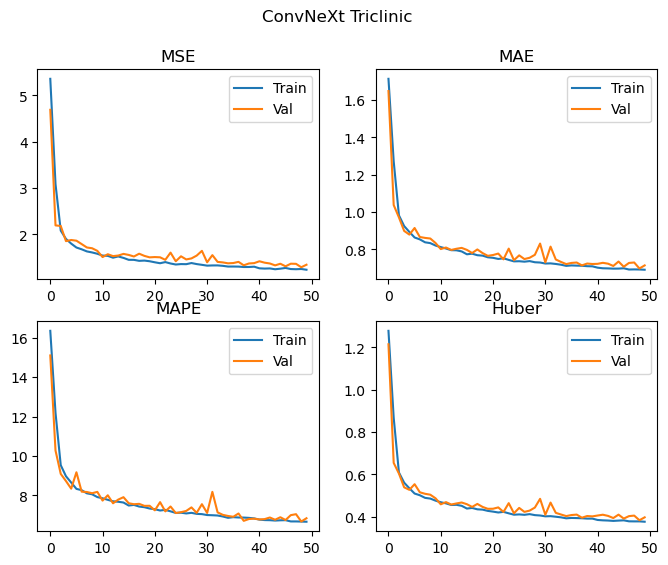


Monoclinic
Training samples = 120031
Validation samples = 30007
Epochs: 50 Total gradient updates: 62500
Best Monoclinic val MSE: 8.420 MAE: 1.867 MAPE: 13.892 Huber: 1.450


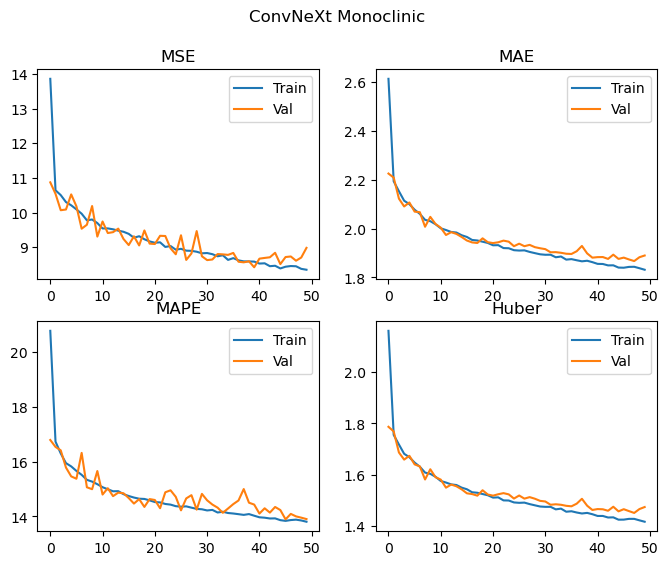


Orthorhombic
Training samples = 40522
Validation samples = 10130
Epochs: 50 Total gradient updates: 21100
Best Orthorhombic val MSE: 6.441 MAE: 1.588 MAPE: 12.986 Huber: 1.183


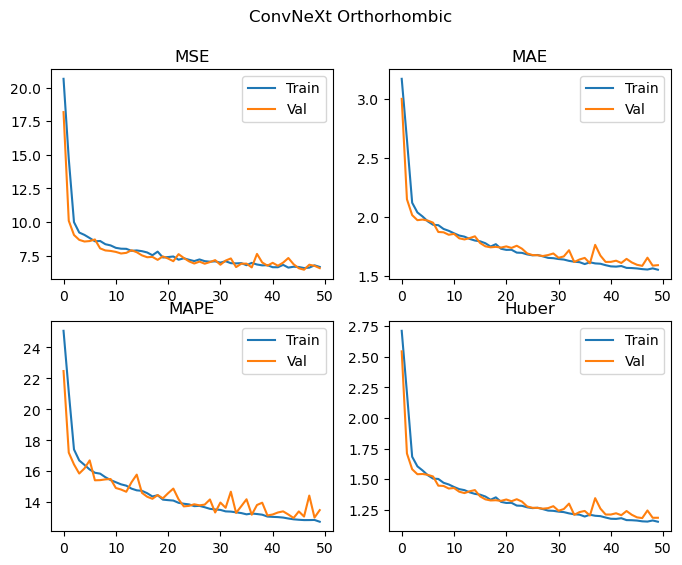

In [9]:
#| code-fold: true
splits = ["Triclinic", "Monoclinic", "Orthorhombic"]
models = []
for i, subset in enumerate([triclinic_data, monoclinic_data, orthorhombic_data]):
    model = ConvNeXt(depths=[2,2,6,2], dims=[4,8,12,16], drop_path_prob=0, dropout=0).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    print(splits[i])
    train_metrics, val_metrics = train(
                                    model=model,
                                    optimizer=optimizer,
                                    idx=subset,
                                    name=f"ConvNeXt_{splits[i]}",
                                    num_epochs=50,
                                    batchsize=(64*3)//2,
                                    show_pbar=False
                                    )

    # Get the minimum validation loss for each metric
    val_min = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0).min(dim=0).values
    print(f"Best {splits[i]} val MSE: {val_min[0]:.3f} MAE: {val_min[1]:.3f} MAPE: {val_min[2]:.3f} Huber: {val_min[3]:.3f}")

    # Calculate the average loss for each epoch and plot
    train_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in train_metrics]], dim=0)
    val_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
    fig.suptitle("ConvNeXt "+splits[i])
    ax[0][0].plot(train_av[:,0])
    ax[0][0].plot(val_av[:,0])
    ax[0][0].title.set_text("MSE")
    ax[0][0].legend(["Train", "Val"])
    ax[0][1].plot(train_av[:,1])
    ax[0][1].plot(val_av[:,1])
    ax[0][1].title.set_text("MAE")
    ax[0][1].legend(["Train", "Val"])
    ax[1][0].plot(train_av[:,2])
    ax[1][0].plot(val_av[:,2])
    ax[1][0].title.set_text("MAPE")
    ax[1][0].legend(["Train", "Val"])
    ax[1][1].plot(train_av[:,3])
    ax[1][1].plot(val_av[:,3])
    ax[1][1].title.set_text("Huber")
    ax[1][1].legend(["Train", "Val"])
    plt.show()
    print()
    models.append(model)

| Crystal system | Chitturi et al - (100/0)     | Chitturi et al - (0/100)        | Replication (50/50) | ConvNeXt v2 (50/50) |
|----------------|------------------------------|---------------------------------|---------------------|---------------------|
| Triclinic      | 7.50                         | 10.48                           | 7.90                | 6.67                |
| Monoclinic     | 13.50                        | 16.02                           | 14.46               | 13.89               |
| Orthorhombic   | 15.71                        | 19.49                           | 19.49               | 12.99               |

This does pretty well! The ConvNeXt v2 model has improved all of the metrics relative to our replication, with a significant improvement in the performance of the orthorhombic crystal system. It's hard to tell with this level of training, but there may be a small amount of divergence between training and validation metrics occuring for the monoclinic data, as such some additional regularisation with DropPath and Dropout enabled may also help further improve performance.

However, the ConvNeXt-based model still has a relatively large number of parameters (about 5k more than our replication of Chitturi's design). Most of these are due to the linear layers at the end of the model, which got me thinking about alternatives.

One option would be to take the output of the final convolutional layer and apply some kind of pooling operation, such as the global average pooling approach used in the original paper. This would reduce the dimensionality of the final linear layer(s) significantly. However, a brief test of this did not result in good performance - the model performed substantially worse than the exiting flatten approach.

However, I wondered if there was a sensible way to _learn how to pool_ the outputs of this layer. The approach I ended up going with was to use a series of [Transformer](https://arxiv.org/abs/1706.03762) encoder blocks with an additional "CLS token" concatenated with the input to these blocks, as was introduced by the [BERT paper](https://arxiv.org/abs/1810.04805). This additional token passes through the transformer blocks as normal, and as such it can attend to all of the other tokens in the sequence. The transformed output of this token is then used for the downstream tasks, such as sentiment analysis etc. It enables the transformer to learn how to efficiently aggregate information from across the sequence, via the multi-head attention mechanism which is beautifully explained by Jay Alammar [here](https://jalammar.github.io/illustrated-transformer/).

In this case, the transformed CLS token is used as the input for the final linear output layer, which gives the predicted unit cell edge lengths.

# Replacing the linear layers with Transformer blocks

Our new model (developed below) has six additional transformer encoder blocks stacked on top of the ConvNeXt v2 blocks, and results in around 30k fewer parameters than we started with! I've set each transformer block to have its own learnable position embedding rather than applying a single global position embedding to the input. This is something that future work could investigate more closely, as well as alternative positional encodings such as [RoPE](https://arxiv.org/abs/2104.09864) or [ALiBi](https://arxiv.org/abs/2108.12409).

Other changes to the original transformer encoder model published by [Vaswani et al](https://arxiv.org/abs/1706.03762) are as follows:
 - Use of GEGLU layers in the feedforward blocks, as described by [Shazeer](https://arxiv.org/abs/2002.05202). These have been shown to improve performance of transformers with no increase in parameter count.
 - Use of the [pre-LN variant](https://arxiv.org/abs/2002.04745) where layer normalisation is applied before the multi-head self attention and feedforward layers rather than after. This helps to stablise training.

 The models now have about 57k parameters, which is a substantial reduction relative to the previous models we've looked at, which had around 80-87k parameters!

In [8]:
#| code-fold: true
class GLU(nn.Module):
    def __init__(self, in_dim, out_dim, act=F.gelu, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim, bias=bias)
        self.linear2 = nn.Linear(in_dim, out_dim, bias=bias)
        self.act = act

    def forward(self, x):
        return self.act(self.linear1(x))*self.linear2(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.qk = nn.Linear(dim, 2*dim)
        self.v = nn.Linear(dim, dim)
        self.mhsa_out = nn.Linear(dim, dim, bias=False)
        self.GLU = GLU(dim, (dim*3)//2, bias=False)
        self.linear_out = nn.Linear((dim*3)//2, dim, bias=False)
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)
        self.pos = nn.Embedding(256, embedding_dim=dim)
        self.dropout = nn.Dropout(dropout)

    def mhsa(self, x):
        B, T, C = x.shape
        q, k = self.qk(x + self.pos(torch.arange(x.shape[1], device=x.device))).chunk(2, dim=-1)
        v = self.v(x)
        q = q.reshape(B, self.heads, T, C//self.heads)
        k = k.reshape(B, self.heads, T, C//self.heads)
        v = v.reshape(B, self.heads, T, C//self.heads)
        x = F.scaled_dot_product_attention(q, k, v)
        x = x.reshape(B, T, C)
        x = self.mhsa_out(x)
        return x

    def ffwd(self, x):
        x = self.GLU(x)
        x = self.linear_out(self.dropout(x))
        return x

    def forward(self, x):
        x = x + self.mhsa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class ConvNeXtTransformer(nn.Module):
    def __init__(self, out_dim=3, depths=[2, 2, 6, 2], dims=[40, 80, 160, 320],
                 transformer_layers=4, transformer_heads=2, drop_path_prob=0.5, dropout=0.1):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        self.initial_conv = nn.Conv1d(1, dims[0], kernel_size=7, stride=2, padding=3)
        self.initial_norm = nn.LayerNorm(dims[0])
        self.conv_layers = nn.ModuleList()
        self.transformer_layers = nn.ModuleList()
        self.cls_token = nn.Embedding(1, dims[-1])
        for i, dd in enumerate(zip(depths, dims)):
            depth, dim = dd
            for d in range(depth):
                self.conv_layers.append(ConvNeXtBlock(dim, drop_path_prob=drop_path_prob))
            if i+1 != len(dims):
                self.conv_layers.append(DownSample(in_dim=dim, out_dim=dims[i+1]))
            #else:
            #    self.conv_layers.append(DownSample(in_dim=dim, out_dim=dims[i]))
        for i in range(transformer_layers):
            self.transformer_layers.append(TransformerBlock(dims[-1], transformer_heads, dropout=dropout))
        self.final_norm = nn.LayerNorm(dims[-1])
        self.output = nn.Sequential(
            GLU(dims[-1], 32),
            nn.Linear(32, out_dim)
        )

    def forward(self, x, shapes=False):
        x = self.initial_conv(x)
        x = self.initial_norm(x.permute(0,2,1)).permute(0,2,1)
        if shapes:
            print(x.shape)
        for l in self.conv_layers:
            x = l(x)
            if shapes:
                print(x.shape)
        x = F.gelu(x)
        # Now concatenate the CLS token with the output of the convolutional layers
        cls = self.cls_token(torch.arange(1, device=x.device)).squeeze().expand(x.shape[0], -1).unsqueeze(-1)
        x = torch.cat([cls, x], dim=-1)
        x = x.permute(0, 2, 1)
        for l in self.transformer_layers:
            x = l(x)
            if shapes:
                print(x.shape)
        x = self.final_norm(x[:,0,:]) # Extract only the CLS token representation
        if shapes:
            print(x.shape)
        x = self.output(x)
        return x

model = ConvNeXtTransformer(depths=[2,2,6,2], dims=[4,8,12,16], transformer_layers=6, transformer_heads=2).to(device)
_ = model(torch.randn(100,1,2048).to(device), shapes=False)
print("Model parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

Model parameters: 57135


Let's train this new model and see how the results compare. We'll also train a model on all three of the cyrstal systems simultaneously to see how it compares.

Triclinic
Training samples = 55230
Validation samples = 13807
Epochs: 50 Total gradient updates: 28750
Best Triclinic val MSE: 1.304 MAE: 0.686 MAPE: 6.544 Huber: 0.376


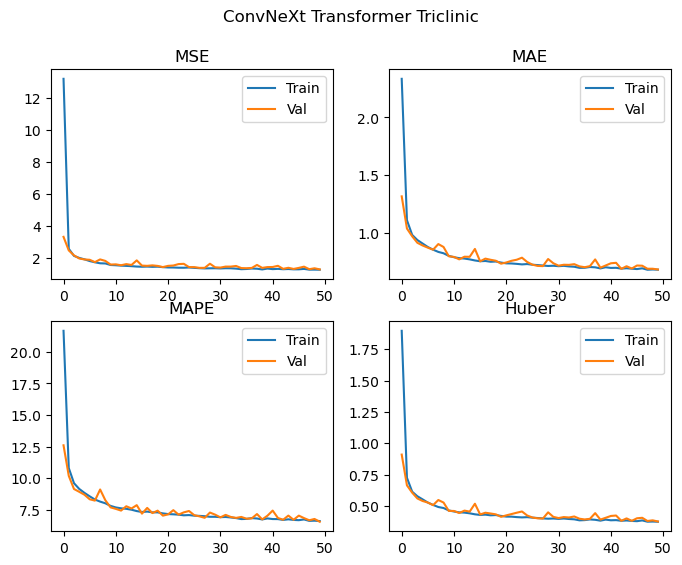


Monoclinic
Training samples = 120031
Validation samples = 30007
Epochs: 50 Total gradient updates: 62500
Best Monoclinic val MSE: 8.661 MAE: 1.844 MAPE: 13.759 Huber: 1.432


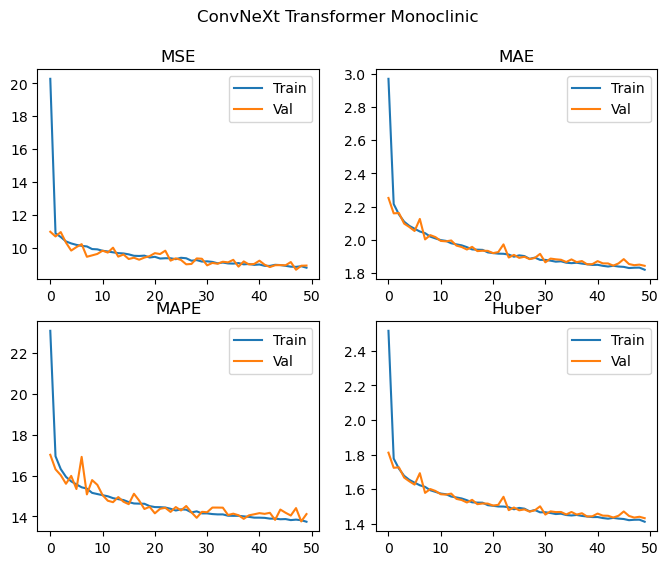


Orthorhombic
Training samples = 40522
Validation samples = 10130
Epochs: 50 Total gradient updates: 21100
Best Orthorhombic val MSE: 6.986 MAE: 1.594 MAPE: 13.380 Huber: 1.192


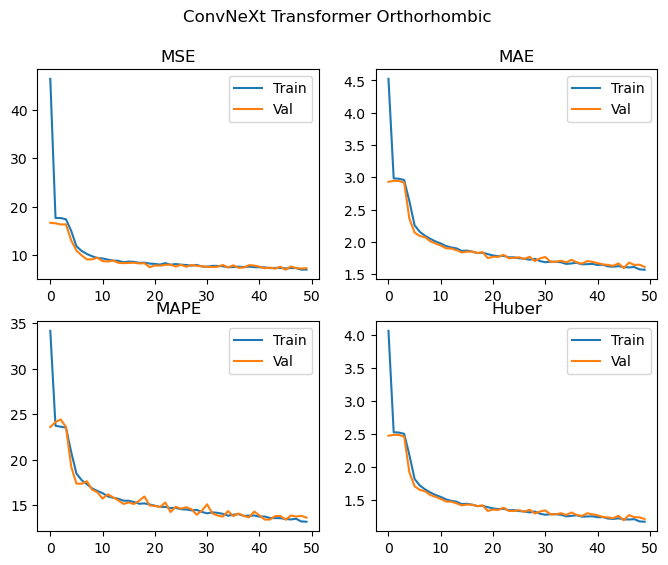


All_Three
Training samples = 215782
Validation samples = 53945
Epochs: 50 Total gradient updates: 112350
Best All_Three val MSE: 10.544 MAE: 1.991 MAPE: 14.974 Huber: 1.581


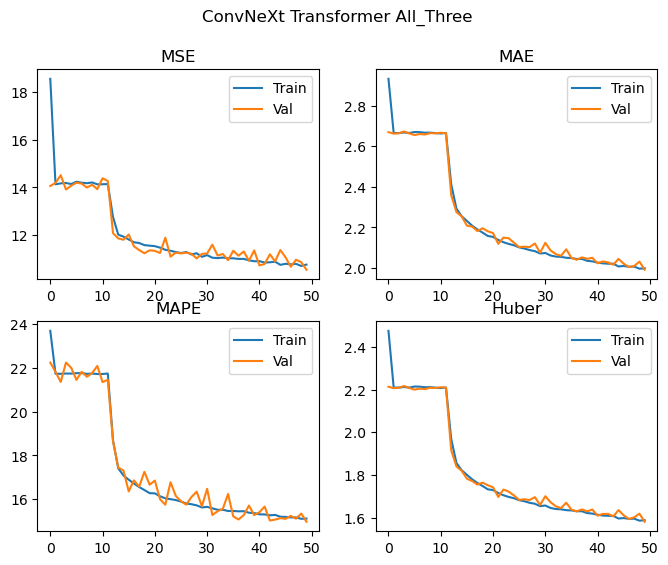

In [8]:
#| code-fold: true
splits = ["Triclinic", "Monoclinic", "Orthorhombic", "All_Three"]
models = []
for i, subset in enumerate([triclinic_data, monoclinic_data, orthorhombic_data, trimonoortho]):
    model = ConvNeXtTransformer(depths=[2,2,6,2], dims=[4,8,12,16], transformer_layers=6, transformer_heads=2,
                                drop_path_prob=0, dropout=0).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    print(splits[i])
    train_metrics, val_metrics = train(
                                    model=model,
                                    optimizer=optimizer,
                                    idx=subset,
                                    name=f"ConvNeXtTransformer{splits[i]}",
                                    num_epochs=50,
                                    batchsize=(64*3)//2,
                                    show_pbar=False
                                    )

    # Get the minimum validation loss for each metric
    val_min = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0).min(dim=0).values
    print(f"Best {splits[i]} val MSE: {val_min[0]:.3f} MAE: {val_min[1]:.3f} MAPE: {val_min[2]:.3f} Huber: {val_min[3]:.3f}")

    # Calculate the average loss for each epoch and plot
    train_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in train_metrics]], dim=0)
    val_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
    fig.suptitle("ConvNeXt Transformer "+splits[i])
    ax[0][0].plot(train_av[:,0])
    ax[0][0].plot(val_av[:,0])
    ax[0][0].title.set_text("MSE")
    ax[0][0].legend(["Train", "Val"])
    ax[0][1].plot(train_av[:,1])
    ax[0][1].plot(val_av[:,1])
    ax[0][1].title.set_text("MAE")
    ax[0][1].legend(["Train", "Val"])
    ax[1][0].plot(train_av[:,2])
    ax[1][0].plot(val_av[:,2])
    ax[1][0].title.set_text("MAPE")
    ax[1][0].legend(["Train", "Val"])
    ax[1][1].plot(train_av[:,3])
    ax[1][1].plot(val_av[:,3])
    ax[1][1].title.set_text("Huber")
    ax[1][1].legend(["Train", "Val"])
    plt.show()
    print()
    models.append(model)

| Crystal system | Chitturi et al - (100/0)     | Chitturi et al - (0/100)        | Replication (50/50) | ConvNeXt v2 (50/50) | ConvNeXt v2 + Transformer (50/50) |
|----------------|------------------------------|---------------------------------|---------------------|---------------------|-----------------------------------|
| Triclinic      | 7.50                         | 10.48                           | 7.90                | 6.67                | 6.54                              |
| Monoclinic     | 13.50                        | 16.02                           | 14.46               | 13.89               | 13.76                             |
| Orthorhombic   | 15.71                        | 19.49                           | 19.49               | 12.99               | 13.38                             |

We achieve effectively the same level of performance despite significantly reducing the number of parameters used by the model! The loss curves are again still decreasing, and we don't see any significant deviations between the training and validation losses, and as such the model is likely to improve with more training epochs. We could probably also scale up the model (with regularization if needed) and achieve even better results.

When training on all of the crystal systems simultaneously, the MAPE achieved is 14.97. Let's see how this multi-crystal-system model performs on each of the crystal systems separately.

In [11]:
def val(model, idx, batchsize=256):
    """
    Get the validation metrics for a trained model on a given subset of the POWCOD training data
    """
    dataset = DiffractionData(base_name, root_dir=root_dir, idx=idx)
    g = torch.Generator().manual_seed(42)
    #train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], g)
    _, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2], g)

    val_dataloader   = DataLoader(val_set,   batch_size=batchsize, shuffle=True)

    all_val_losses = []
    val_losses = get_loss(val_dataloader, model, optimizer, 1, train=False, show_pbar=False)
    all_val_losses.append(val_losses)
    val_losses = torch.cat(val_losses, dim=0).mean(dim=0)
    return all_val_losses

In [12]:
splits = ["Triclinic", "Monoclinic", "Orthorhombic", "All_Three"]
for i, subset in enumerate([triclinic_data, monoclinic_data, orthorhombic_data]):
    model = models[-1]
    val_metrics = val(
                                    model=model,
                                    idx=subset,
                                    batchsize=(64*3)//2,
                                    )

    # Get the minimum validation loss for each metric
    val_min = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0).min(dim=0).values
    print(f"Best {splits[i]} val MSE: {val_min[0]:.3f} MAE: {val_min[1]:.3f} MAPE: {val_min[2]:.3f} Huber: {val_min[3]:.3f}")

    val_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0)

Best Triclinic val MSE: 6.420 MAE: 1.652 MAPE: 15.435 Huber: 1.255
Best Monoclinic val MSE: 11.334 MAE: 2.081 MAPE: 14.739 Huber: 1.667
Best Orthorhombic val MSE: 13.068 MAE: 2.091 MAPE: 14.354 Huber: 1.683


The model trained on multiple crystal systems does worse at each one, though still improves on our replication of Chitturi et al's model for the monoclinic and orthorhombic crystal systems. I wonder if the model is simultaneously trained to determine the crystal system if this might improve the performance on the triclinic unit cell.

Let's modify the model now to do a couple of new things:
1. I want it to be able to predict the crystal system
2. I want it to be able to provide a level of uncertainty for each of the unit cell edges it determimines

This will require us to change the output of the model slightly, as well as modify the loss function.


# Incorporating classification and uncertainty

For the classification task, we will need to add an output head of 3 neurons (to represent each of the possible crystal systems), and for the unit cell edges task, we'll need to add three additional neurons to characterise the model's level of uncertainty.

The loss function will then need to include the cross entropy loss for classification. To incorporate uncertainty for the cell edges, we'll treat the task as determining the mean and variance of a gaussian function. The loss function for the cell edges will become the following:

$$
L_{edges} = -\sum_{i=1}^{I}{\log\left[ \frac{1}{\sqrt{2\pi(f_2(x_i)))2}}\right] - \frac{(y_i-f_1(x_i))^2}{2f_2(x_i)^2}}
$$

$$
= \sum_{i=1}^{I}{\frac{(y_i-f_1(x_i))^2}{2f_2(x_i)^2} - \log\left[ \frac{1}{\sqrt{2\pi(f_2(x_i)))2}}\right]}
$$

Where $f_1(x)$ is the predicted cell edge (i.e. the mean of the gaussian), and $f_2(x)$ is the uncertainty of the model (i.e. the standard deviation of the gaussian).

The loss function that will be minimuised by training the model then becomes:

$$
L = \alpha CE + (1-\alpha)L_{edges}
$$

Where CE is the cross-entropy loss for the classification task, and alpha is a parameter that we can set to balance the relative magnitudes of the contributions to the loss.

In [31]:
class ConvNeXtTransformerWithClassAndUncertainty(nn.Module):
    def __init__(self, out_dim_cs=3, out_dim_cell_edges=6, depths=[2, 2, 6, 2], dims=[40, 80, 160, 320],
                 transformer_layers=4, transformer_heads=2, drop_path_prob=0.5, dropout=0.1):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        self.initial_conv = nn.Conv1d(1, dims[0], kernel_size=7, stride=2, padding=3)
        self.initial_norm = nn.LayerNorm(dims[0])
        self.conv_layers = nn.ModuleList()
        self.transformer_layers = nn.ModuleList()
        self.cls_tokens = nn.Embedding(2, dims[-1])
        for i, dd in enumerate(zip(depths, dims)):
            depth, dim = dd
            for d in range(depth):
                self.conv_layers.append(ConvNeXtBlock(dim, drop_path_prob=drop_path_prob))
            if i+1 != len(dims):
                self.conv_layers.append(DownSample(in_dim=dim, out_dim=dims[i+1]))
            #else:
            #    self.conv_layers.append(DownSample(in_dim=dim, out_dim=dims[i]))
        for i in range(transformer_layers):
            self.transformer_layers.append(TransformerBlock(dims[-1], transformer_heads, dropout=dropout))
        self.final_norm = nn.LayerNorm(dims[-1])
        self.output_crystal_system = nn.Sequential(
            GLU(dims[-1], 32),
            nn.Linear(32, out_dim_cs)
            )
        self.output_cell_edges = nn.Sequential(
            GLU(dims[-1], 32),
            nn.Linear(32, out_dim_cell_edges)
            )

    def forward(self, x, shapes=False):
        x = self.initial_conv(x)
        x = self.initial_norm(x.permute(0,2,1)).permute(0,2,1)
        if shapes:
            print(x.shape)
        for l in self.conv_layers:
            x = l(x)
            if shapes:
                print(x.shape)
        x = F.gelu(x)
        # Now concatenate the CLS token with the output of the convolutional layers
        cls = self.cls_tokens(torch.arange(2, device=x.device)).expand(x.shape[0], 2, -1).permute(0,2,1)
        x = torch.cat([cls, x], dim=-1)
        x = x.permute(0, 2, 1)
        for l in self.transformer_layers:
            x = l(x)
            if shapes:
                print(x.shape)
        x_cell = self.final_norm(x[:,0,:]) # Extract only the CLS token representation
        x_cs = self.final_norm(x[:,1,:]) # Extract only the CLS token representation
        if shapes:
            print(x.shape)
        pred_cell_edges = self.output_cell_edges(x_cell)
        pred_crystal_system = self.output_crystal_system(x_cs)
        return pred_cell_edges, pred_crystal_system

model = ConvNeXtTransformerWithClassAndUncertainty(depths=[2,2,6,2], dims=[4,8,12,16], transformer_layers=6, transformer_heads=2).to(device)
_ = model(torch.randn(100,1,2048).to(device), shapes=False)
print("Model parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

Model parameters: 58437


A very slight increase in the number of parameters! We now need to modify the training loop to account for the new loss function

In [48]:
#| code-fold: true
# Training / validation code
def get_loss_classification_uncertainty(dataloader, model, optimizer, epoch, cs_weights, train=True, show_pbar=True, alpha=0.5):
    """
    Get the losses for an epoch. Toggle between the dataloaders so the same code can be recycled
    for the training and validation sets.
    """
    if show_pbar:
        pbar = tqdm(dataloader)
    else:
        pbar = dataloader
    logs = []
    if not train:
        model.eval()
    for batch_cs, batch_hkl, batch_i, batch_cell, batch_sg_number in pbar:
        # zero the parameter gradients
        optimizer.zero_grad(set_to_none=True)
        # forward + backward + optimize
        if len(batch_cs) % 2 != 0 or len(batch_cs) % 3 != 0:
            maxlength = 6*(batch_cs.shape[0]//6)
            batch_cs = batch_cs[:maxlength]
            batch_hkl = batch_hkl[:maxlength]
            batch_i = batch_i[:maxlength]
            batch_cell = batch_cell[:maxlength]
            batch_sg_number = batch_sg_number[:maxlength]
        calcdata = patterns.calculate_diffraction_patterns_with_impurities(
                                        x,
                                        full_data,
                                        batch_cs.to(device),
                                        batch_hkl.to(device),
                                        batch_i.to(device),
                                        batch_cell.to(device),
                                        batch_sg_number.to(device),
                                        same_hwhm=same_hwhm,
                                        min_impurity_intensity=min_impurity_intensity,
                                        max_impurity_intensity=max_impurity_intensity,
                                        add_background = add_background,
                                    )
        combined, pure_patterns, impure_patterns, pure_impure, cs, cell, sgs, hkls = calcdata
        cs = cs.type(dtype)
        cs[cs == 5] = 0 # Triclinic
        cs[cs == 2] = 1 # Monoclinic
        cs[cs == 3] = 2 # Orthorhombic
        cell_mean_sigma, cs_pred_logits = model(combined.unsqueeze(1))
        abc_pred = cell_mean_sigma[:,:3]
        abc_sigma = cell_mean_sigma[:,3:]
        sorted_cell = torch.sort(cell[:,:3], dim=1).values
        mse = F.mse_loss(abc_pred, sorted_cell)
        mae = torch.abs(abc_pred - sorted_cell).mean()
        huber = F.huber_loss(abc_pred, sorted_cell)
        mape = (100*torch.abs(abc_pred - sorted_cell)/sorted_cell).mean()
        accuracy = (torch.argmax(cs_pred_logits, dim=-1) == cs.type(torch.long)).sum() / cs.shape[0]
        cell_edge_loss = (((sorted_cell-abc_pred)**2/(2*abc_sigma**2))-torch.log(1/torch.sqrt(2*torch.pi*abc_sigma**2))).sum(dim=-1)
        cross_entropy_loss = F.cross_entropy(cs_pred_logits, cs.type(torch.long), weight=cs_weights, reduction="none")
        loss = (alpha*cross_entropy_loss + (1-alpha)*cell_edge_loss).mean()
        if train:
            loss.backward()
            optimizer.step()
        if show_pbar:
            pbar.set_description_str(f"Epoch: {epoch+1} MAPE : {mape:.4f} Accuracy : {accuracy.item():.4f} Edge-loss : {(1-alpha)*cell_edge_loss.mean().item():.4f} Cross-Ent : {alpha*cross_entropy_loss.mean().item():.4f} Loss : {loss.item():.4f}")
        logs.append(torch.tensor([[mse, mae, mape, huber, accuracy]]))
    if not train:
        model.train()
    return logs

def get_crystal_system_weights(idx):
    """
    Train a model on a given subset of the POWCOD training data
    """
    dataset = DiffractionData(base_name, root_dir=root_dir, idx=idx)
    g = torch.Generator().manual_seed(42)
    #train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], g)
    train_set, _ = torch.utils.data.random_split(dataset, [0.8, 0.2], g)

    cs = []
    for batch_cs, _, _, _, _ in train_set:
        cs.append(batch_cs)
    cs = np.array(cs)
    cs[cs == 5] = 0 # Triclinic
    cs[cs == 2] = 1 # Monoclinic
    cs[cs == 3] = 2 # Orthorhombic
    cs = np.unique(cs, return_counts=True)[1]
    # Balanced weights as described here - https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
    cs = cs.sum() / (len(cs) * cs)
    return torch.tensor(cs, device=device, dtype=dtype)

def train_classification_uncertainty(model, optimizer, idx, name, batchsize=256, num_epochs=50, show_pbar=True, alpha=0.5):
    """
    Train a model on a given subset of the POWCOD training data
    """
    dataset = DiffractionData(base_name, root_dir=root_dir, idx=idx)
    g = torch.Generator().manual_seed(42)
    #train_set, val_set, test_set = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1], g)
    train_set, val_set = torch.utils.data.random_split(dataset, [0.8, 0.2], g)

    train_dataloader = DataLoader(train_set, batch_size=batchsize, shuffle=True)
    val_dataloader   = DataLoader(val_set,   batch_size=batchsize, shuffle=True)
    #test_dataloader  = DataLoader(test_set,  batch_size=batchsize, shuffle=True)

    print(f"Training samples = {len(train_set)}\nValidation samples = {len(val_set)}")#\nTest samples = {len(test_set)}")

    num_steps = (len(train_set)//batchsize) * num_epochs
    print(f"Epochs: {num_epochs} Total gradient updates: {num_steps}")
    cs_weights = get_crystal_system_weights(idx)
    all_train_losses = []
    all_val_losses = []
    best_val_mape = float("inf")
    for epoch in range(num_epochs):
        train_losses = get_loss_classification_uncertainty(train_dataloader, model, optimizer, epoch, cs_weights, train=True, show_pbar=show_pbar, alpha=alpha)
        all_train_losses.append(train_losses)
        train_losses = torch.cat(train_losses, dim=0).mean(dim=0)
        with torch.no_grad():
            val_losses = get_loss_classification_uncertainty(val_dataloader, model, optimizer, epoch, cs_weights, train=False, show_pbar=show_pbar, alpha=alpha)
        all_val_losses.append(val_losses)
        val_losses = torch.cat(val_losses, dim=0).mean(dim=0)
        if show_pbar:
            print(f"Train: MSE {train_losses[0]:.3f} MAE {train_losses[1]:.3f} MAPE {train_losses[2]:.3f} Huber {train_losses[3]:.3f} Accuracy {train_losses[4]:.3f}")
            print(f"  Val: MSE {val_losses[0]:.3f} MAE {val_losses[1]:.3f} MAPE {val_losses[2]:.3f} Huber {val_losses[3]:.3f} Accuracy {train_losses[4]:.3f}")
        if val_losses[2] < best_val_mape:
            best_val_mape = val_losses[2]
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f"saved_models/{name}.pth")
    return all_train_losses, all_val_losses

In [49]:
#| code-fold: true
splits = ["All_Three"]
models = []
for i, subset in enumerate([trimonoortho]):
    model = ConvNeXtTransformerWithClassAndUncertainty(depths=[2,2,6,2], dims=[4,8,12,16], transformer_layers=6, transformer_heads=2,
                                drop_path_prob=0, dropout=0).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=6e-4)
    print(splits[i])
    train_metrics, val_metrics = train_classification_uncertainty(
                                    model=model,
                                    optimizer=optimizer,
                                    idx=subset,
                                    name=f"ConvNeXtTransformer{splits[i]}",
                                    num_epochs=50,
                                    batchsize=(64*3)//2,
                                    show_pbar=True,
                                    alpha=0.99,
                                    )

    # Get the minimum validation loss for each metric
    val_min = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0).min(dim=0).values
    print(f"Best {splits[i]} val MSE: {val_min[0]:.3f} MAE: {val_min[1]:.3f} MAPE: {val_min[2]:.3f} Huber: {val_min[3]:.3f}")

    # Calculate the average loss for each epoch and plot
    train_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in train_metrics]], dim=0)
    val_av = torch.cat([x.mean(dim=0,keepdim=True) for x in [torch.cat(y, dim=0) for y in val_metrics]], dim=0)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
    fig.suptitle("ConvNeXt Transformer "+splits[i])
    ax[0][0].plot(train_av[:,0])
    ax[0][0].plot(val_av[:,0])
    ax[0][0].title.set_text("MSE")
    ax[0][0].legend(["Train", "Val"])
    ax[0][1].plot(train_av[:,1])
    ax[0][1].plot(val_av[:,1])
    ax[0][1].title.set_text("MAE")
    ax[0][1].legend(["Train", "Val"])
    ax[1][0].plot(train_av[:,2])
    ax[1][0].plot(val_av[:,2])
    ax[1][0].title.set_text("MAPE")
    ax[1][0].legend(["Train", "Val"])
    ax[1][1].plot(train_av[:,3])
    ax[1][1].plot(val_av[:,3])
    ax[1][1].title.set_text("Huber")
    ax[1][1].legend(["Train", "Val"])
    plt.show()
    print()
    models.append(model)

All_Three
Training samples = 215782
Validation samples = 53945
Epochs: 50 Total gradient updates: 112350


  0%|          | 0/2248 [00:00<?, ?it/s]

  0%|          | 0/562 [00:00<?, ?it/s]

UnboundLocalError: cannot access local variable 'loss' where it is not associated with a value

# Conclusions

We were able to replicate the results described by Chitturi et al using the PowCodGen code we developed in a previous post. Using more modern architectural choices, we were able to improve the performance of the model whilst also reducing the number of parameters it required!

We've also seen that the discrepancy in performance between models trained exclusively on triclinic data relative to those trained on monoclinic and orthorhombic data can be explained in part by [XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX]. 

In my next post, we'll look at a more novel use of neural networks in this context, which may be of interest to users with data that is proving difficult to index!